## What was I Working On when I Quit:
 - Pipeline is working! 
 - Basic tested a bunch of models, XGBRegressor seemed to do best with almost no changes from default
 - Add polynomial features and see how that works
- im using this link to learn about preprocessing https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

# Project Beginning
## Run all cells below until the section of not required to run cells

In [87]:
#import a bunch of stuff thats used later
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold


In [88]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.set_option('mode.chained_assignment', None)

## Note - House_data was previously cleaned in R in the following ways:
 - Dropping columns that were highly correlated with others (>0.85)
 - Dropping columns with more lots of NAs (>90%)

In [89]:

house_data = pd.read_csv("C:/Users/isaac/Desktop/Kaggle Comp Housing Prices/clean_train.csv")
house_data.drop(['Unnamed: 0', 'Id'], axis = 1,inplace = True)
test_data = pd.read_csv("C:/Users/isaac/Desktop/Kaggle Comp Housing Prices/test.csv")

In [90]:
#Assign y and X variables
y = house_data.SalePrice
X = house_data.drop(['SalePrice'], axis = 1)

In [91]:
#Set Global Random Seed
np.random.seed(213)

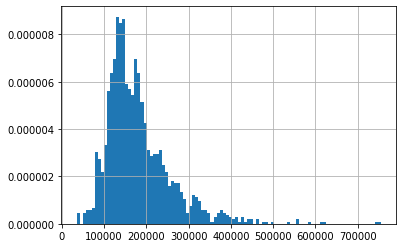

In [92]:
#Y has a few crazy outliers
plt = house_data.SalePrice.hist(cumulative=False, density=1, bins=100)
plt


## Pipeline the Preprocessing 

In [93]:
#List column names for pipe again
num_cols = ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF"]
ord_cols = ["ExterQual","ExterCond","BsmtQual","HeatingQC","KitchenQual", "FireplaceQu"]
OH_cols = list(set(X.columns) - set(num_cols) - set(ord_cols))
all_cols = X.columns

In [131]:
#============ Pipeline Entire Data preprocessing =================#

class NominalFixer(BaseEstimator, TransformerMixin): #Create Sklearn style transformer for ordinal data

    def __init__(self):
        pass  # e.g. pass in a column name to extract


    def transform(self, X, y=None):
        def orderizer(df, order_cats = ['missing', 'Po', 'Fa', 'TA', 'Gd','Ex']):
            for col in df.columns:
                cat = pd.Categorical(df[col],
                                    categories = order_cats,
                                     ordered = True)
                cat = cat.fillna('missing')
                labels, unique = pd.factorize(cat, sort=True)
                df[col] = labels
        orderizer(X)
        return X  

    def fit(self, X, y=None):
        return self  
class Stringer(BaseEstimator, TransformerMixin): #Create Sklearn style transformer for turing OH columns into strings

    def __init__(self):
        pass  # e.g. pass in a column name to extract


    def transform(self, X, y=None):
        X = X.astype(str)
        return X  

    def fit(self, X, y=None):
        return self 

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('binner', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')),
        ('std_scaler', StandardScaler()),
    ])

ord_pipeline = Pipeline([
        ('orderizer', NominalFixer())
    ])

OH_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant")),
        ('stringer', Stringer()),
        ('OH_enc', OneHotEncoder(sparse = False, handle_unknown = 'ignore')),
    ])




In [132]:
#Full Pipeline that combines the pipelines above and transformers specified columns (Outputs an array)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("OH", OH_pipeline, OH_cols),
        ("ord", ord_pipeline, ord_cols)
    ])

## Remove Outliers and Reselect X,y

In [133]:
#Use Isolation Forest to detect outliers
isofor = IsolationForest(random_state = 213)
isofor.fit(full_pipeline.fit_transform(house_data))
outliers = pd.DataFrame(isofor.predict(full_pipeline.fit_transform(house_data)), index=house_data.index)

In [134]:
#Get index in data of predicted outliers
outlier_index = outliers[outliers[0] != 1].index


In [136]:
house_data_new = house_data.drop(outlier_index,).reset_index()

In [137]:
#Assign y and X variables
y = house_data_new.SalePrice
X = house_data_new.drop(['SalePrice'], axis = 1)

In [138]:
#Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


## Test Different Models

 - Highest MSE:
 - 28261.97 with XGBRegressor

In [139]:
#Process training and test data
X_train_piped = full_pipeline.fit_transform(X_train)
X_test_piped = full_pipeline.transform(X_test)

C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 10 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [140]:
# Stratified K Fold Cross Validation Function

def model_test_kfold(X,y, model, num_splits):
    skf = StratifiedKFold(n_splits=num_splits, random_state=213, shuffle=False) #5 Split K Fold
    
    X_piped = full_pipeline.fit_transform(X) #Transform raw data
    all_rmse = []
    n = 1
    for train_index, test_index in skf.split(X_piped, y):
        print("Training Split ", n)
        X_train, X_test = X_piped[train_index], X_piped[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse.append(rmse)
        print('RMSE: ', rmse)
        print('Fold ', n, " Complete")
        n = n +1
    return np.mean(all_rmse)

In [141]:
#### Model Im happy with
model_test_kfold(X,y,XGBRegressor(objective ='reg:squarederror', random_state=213,learning_rate = 0.13, n_estimators = 300), 5)

C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 10 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  31998.85686720701
Fold  1  Complete
Training Split  2
RMSE:  21099.574859219032
Fold  2  Complete
Training Split  3
RMSE:  18645.267913100528
Fold  3  Complete
Training Split  4
RMSE:  17451.29441653229
Fold  4  Complete
Training Split  5
RMSE:  23412.636321766167
Fold  5  Complete


22521.52607556501

In [ ]:
21216.783288565846

## Tune XGBRegressor 

In [146]:
xgb = XGBRegressor()
parameters = {'objective':['reg:squarederror'], 'random_state': [213],
              'learning_rate': [.03, 0.05, .07, .1, .15], 
              'n_estimators': [1000]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
xgb_grid.fit(X_train_piped, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_test_piped, y_test)], 
             verbose=False)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:   19.8s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=5,
             param_grid={'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.15],
                         'n_estimators': [1000],
   

In [148]:
xgb_grid.best_params_

{'learning_rate': 0.1,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'random_state': 213}

#  Not Required to Run Cells  
##  Mostly for reference

## Preprocess Numeric Variables

In [7]:
#Assign numeric variables
num_cols = ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF"]

In [9]:
#Prepare Numeric Columns
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
X_train_new = num_pipeline.fit_transform(X_train[num_cols])
X_test_new = num_pipeline.transform(X_test[num_cols])


## Preprocess Categoric Variables

In [12]:
#Collect Nomial Columns to One Hot Encode
OH_cols = set(X.columns) - set(num_cols) - set(all_ordinal_cols)
OH_cols = list(OH_cols)
#X_train[OH_cols]

In [13]:
#Replace NAs
si = SimpleImputer(strategy='constant')

X_train[OH_cols] =si.fit_transform(X_train[OH_cols])
X_test[OH_cols] = si.transform(X_test[OH_cols])


C:\Users\isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\isaac\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [14]:
#OH Encode
onehot = OneHotEncoder()

OH_train = pd.DataFrame(
    onehot.fit_transform(X_train[OH_cols].astype(str)).toarray())
OH_test = pd.DataFrame(
    onehot.fit_transform(X_test[OH_cols].astype(str)).toarray())

In [48]:
#Drop all variables we OH encoded from original DataFrame
X_train = X_train.drop(OH_cols, axis = 1)
X_test = X_test.drop(OH_cols, axis = 1)

## Preprocess Ordinal Variables

In [19]:
#Columns to binarize

all_ordinal_cols = ["OverallQual","OverallCond","ExterQual","ExterCond","BsmtQual","HeatingQC","KitchenQual", "FireplaceQu"]
ord_cols = ["ExterQual","ExterCond","BsmtQual","HeatingQC","KitchenQual", "FireplaceQu"]

In [72]:
# Assign Order (OverallQual and OverallCond do not need to be converted as they are already 1-10)
  
from sklearn.base import BaseEstimator, TransformerMixin

# def orderizer(df,ord_cols, order_cats = ['missing', 'Po', 'Fa', 'TA', 'Gd','Ex']):
#     for col in ord_cols:
#         cat = pd.Categorical(df[col],
#                             categories = order_cats,
#                              ordered = True)
#         cat = cat.fillna('missing')
#         labels, unique = pd.factorize(cat, sort=True)
#         df[col] = labels


class NominalFixer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass  # e.g. pass in a column name to extract
    

    def transform(self, X, y=None):
        def orderizer(df, order_cats = ['missing', 'Po', 'Fa', 'TA', 'Gd','Ex']):
            for col in df.columns:
                cat = pd.Categorical(df[col],
                                    categories = order_cats,
                                     ordered = True)
                cat = cat.fillna('missing')
                labels, unique = pd.factorize(cat, sort=True)
                df[col] = labels
        ord_df = orderizer(X)
        return X  # where the actual feature extraction happens

    def fit(self, X, y=None):
        return self  # generally does nothing        
        
#Original For Code that was turned into above function
#   for col in ordinal_encode_cols:
#         cat = pd.Categorical(X_train[col],
#                             categories = ['missing', 'Po', 'Fa', 'TA', 'Gd','Ex'],
#                              ordered = True)
#         cat = cat.fillna('missing')
#         labels, unique = pd.factorize(cat, sort=True)
#         X_train[col] = labels
#         cat = pd.Categorical(X_test[col],
#                             categories = ['missing', 'Po', 'Fa', 'TA', 'Gd','Ex'],
#                              ordered = True)
#         cat = cat.fillna('missing')
#         labels, unique = pd.factorize(cat, sort=True)
#         X_test[col] = labels

## Misc

In [26]:
#test model function, scoring method is RMSE
def model_test(model, X_train = X_train_piped, X_test = X_test_piped):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [129]:
#Remove observations with abnormally high sale price
upperlimit = np.mean(house_data_new.SalePrice)+(3*np.std(house_data_new.SalePrice))
upperlimit_index = house_data_new.SalePrice[house_data_new.SalePrice > upperlimit].index
house_data_new = house_data.drop(upperlimit_index,).reset_index()

In [25]:
#Test a bunch of different models to see whats best
model_names = ['SVR - Linear','SVR - RBF', 'Logit', 'Decision Tree', 'Random Forest', 'MLP',
               'KNN','Ada Boost', 'Gaussian NB',
               'Gradient Boosting', 'XGBoost']
models = [SVR(kernel = 'linear'), SVR(kernel = 'rbf'), LogisticRegression(), DecisionTreeRegressor(), RandomForestRegressor(), MLPRegressor(), KNeighborsRegressor(), 
          AdaBoostRegressor(), GaussianNB(), GradientBoostingRegressor(),
          XGBRegressor(objective ='reg:squarederror')]


result_list = []
for i in range(len(models)):
    result = model_test_kfold(X,y,models[i], 5)
    print('model ' + model_names[i] + ' tested')
    print(result)
    result_list.append([model_names[i], result])
model_test_results = pd.DataFrame(result_list, columns=['Model', 'RMSE']) #store results in a pretty dataframe

C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  102200.48082020735
Fold  1  Complete
Training Split  2
RMSE:  53234.854000079125
Fold  2  Complete
Training Split  3
RMSE:  44937.521143537044
Fold  3  Complete
Training Split  4
RMSE:  41871.955740951256
Fold  4  Complete
Training Split  5
RMSE:  35436.721030725785
Fold  5  Complete
model SVR - Linear tested
55536.30654710012


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  105698.21778161725
Fold  1  Complete
Training Split  2
RMSE:  58751.72317267036
Fold  2  Complete
Training Split  3
RMSE:  50459.27888777085
Fold  3  Complete
Training Split  4
RMSE:  47438.320811267
Fold  4  Complete
Training Split  5
RMSE:  40727.552978016305
Fold  5  Complete
model SVR - RBF tested
60615.018726268354


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  65126.041234746
Fold  1  Complete
Training Split  2
RMSE:  34791.64035604636
Fold  2  Complete
Training Split  3
RMSE:  33563.01979607442
Fold  3  Complete
Training Split  4
RMSE:  44344.30004594599
Fold  4  Complete
Training Split  5
RMSE:  29835.874012468816
Fold  5  Complete
model Logit tested
41532.17508905632


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  54069.86808141416
Fold  1  Complete
Training Split  2
RMSE:  34162.59659729829
Fold  2  Complete
Training Split  3
RMSE:  34537.74563194063
Fold  3  Complete
Training Split  4
RMSE:  38191.79811653342
Fold  4  Complete
Training Split  5
RMSE:  32342.447260901205
Fold  5  Complete
model Decision Tree tested
38660.891137617546


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  51261.18685767407
Fold  1  Complete
Training Split  2
RMSE:  21590.739306533655
Fold  2  Complete
Training Split  3
RMSE:  23396.905119822793
Fold  3  Complete
Training Split  4
RMSE:  26884.438465233303
Fold  4  Complete
Training Split  5
RMSE:  25009.7873426398
Fold  5  Complete
model Random Forest tested
29628.61141838073
Training Split  1


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RMSE:  215885.06796064004
Fold  1  Complete
Training Split  2


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RMSE:  170783.6230903836
Fold  2  Complete
Training Split  3


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RMSE:  156343.94379632943
Fold  3  Complete
Training Split  4


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RMSE:  157549.63887504788
Fold  4  Complete
Training Split  5


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


RMSE:  156587.56622955896
Fold  5  Complete
model MLP tested
171429.96799039198
Training Split  1
RMSE:  54625.17481456565
Fold  1  Complete
Training Split  2
RMSE:  21723.28028604457
Fold  2  Complete
Training Split  3
RMSE:  20951.74196369522
Fold  3  Complete
Training Split  4
RMSE:  41051.494201534566
Fold  4  Complete
Training Split  5
RMSE:  22499.327878029533
Fold  5  Complete
model KNN tested
32170.20382877391


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  54643.40828546865
Fold  1  Complete
Training Split  2
RMSE:  30606.429051284358
Fold  2  Complete
Training Split  3
RMSE:  30868.30860970929
Fold  3  Complete
Training Split  4
RMSE:  30016.578551521063
Fold  4  Complete
Training Split  5
RMSE:  30152.55873954741
Fold  5  Complete
model Ada Boost tested
35257.45664750615


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  92692.39575788332
Fold  1  Complete
Training Split  2
RMSE:  45215.87983743857
Fold  2  Complete
Training Split  3
RMSE:  40600.96813945926
Fold  3  Complete
Training Split  4
RMSE:  34417.167959924875
Fold  4  Complete
Training Split  5
RMSE:  32611.298857709015
Fold  5  Complete
model Gaussian NB tested
49107.54211048301
Training Split 

C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


 1
RMSE:  48503.205434867894
Fold  1  Complete
Training Split  2
RMSE:  19604.895431696816
Fold  2  Complete
Training Split  3
RMSE:  20578.578253020667
Fold  3  Complete
Training Split  4
RMSE:  20488.26050064888
Fold  4  Complete
Training Split  5
RMSE:  22757.19865273993
Fold  5  Complete
model Gradient Boosting tested
26386.427654594834


C:\Users\isaac\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training Split  1
RMSE:  48354.547450752005
Fold  1  Complete
Training Split  2
RMSE:  19820.04695969139
Fold  2  Complete
Training Split  3
RMSE:  20486.330514141984
Fold  3  Complete
Training Split  4
RMSE:  22019.631429401084
Fold  4  Complete
Training Split  5
RMSE:  22703.8021896678
Fold  5  Complete
model XGBoost tested
26676.871708730854
